<a href="https://colab.research.google.com/github/alyonanf/HFT/blob/main/future_midprice_stoikov_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log
from typing import List, Optional, Tuple, Union, Deque, Dict


In [117]:
gamma = 0.1
sigma = 2
k = 1.5	
delta = gamma*sigma*sigma +2/gamma * log(1+gamma/k)

q = 0


In [118]:
from collections import deque
from dataclasses import dataclass
from sortedcontainers import SortedDict


@dataclass
class Order:  # Our own placed order
    place_ts : float # ts when we place the order
    exchange_ts : float # ts when exchange(simulator) get the order    
    order_id: int
    side: str
    size: float
    price: float

        
@dataclass
class CancelOrder:
    exchange_ts: float
    id_to_delete : int

@dataclass
class AnonTrade:  # Market trade
    exchange_ts : float
    receive_ts : float
    side: str
    size: float
    price: float


@dataclass
class OwnTrade:  # Execution of own placed order
    place_ts : float # ts when we call place_order method, for debugging
    exchange_ts: float
    receive_ts: float
    trade_id: int
    order_id: int
    side: str
    size: float
    price: float
    execute : str # BOOK or TRADE


    def __post_init__(self):
        assert isinstance(self.side, str)

@dataclass
class OrderbookSnapshotUpdate:  # Orderbook tick snapshot
    exchange_ts : float
    receive_ts : float
    asks: list  # [tuple[price, size]]
    bids: list


@dataclass
class MdUpdate:  # Data of a tick
    exchange_ts : float
    receive_ts : float
    orderbook: Optional[OrderbookSnapshotUpdate] = None
    trade: Optional[AnonTrade] = None


def update_best_positions(best_bid:float, best_ask:float, md:MdUpdate) -> Tuple[float, float]:
    if not md.orderbook is None:
        best_bid = md.orderbook.bids[0][0]
        best_ask = md.orderbook.asks[0][0]
    return best_bid, best_ask


class Sim:
    def __init__(self, market_data: List[MdUpdate], execution_latency: float, md_latency: float) -> None:
        '''
            Args:
                market_data(List[MdUpdate]): market data
                execution_latency(float): latency in nanoseconds
                md_latency(float): latency in nanoseconds
        '''   
        #transform md to queue
        self.md_queue = deque( market_data )
        #action queue
        self.actions_queue:Deque[ Union[Order, CancelOrder] ] = deque()
        #SordetDict: receive_ts -> [updates]
        self.strategy_updates_queue = SortedDict()
        #map : order_id -> Order
        self.ready_to_execute_orders:Dict[int, Order] = {}
        
        #current md
        self.md:Optional[MdUpdate] = None
        #current ids
        self.order_id = 0
        self.trade_id = 0
        #latency
        self.latency = execution_latency
        self.md_latency = md_latency
        #current bid and ask
        self.best_bid = -np.inf
        self.best_ask = np.inf
        #current trade 
        self.trade_price = {}
        self.trade_price['BID'] = -np.inf
        self.trade_price['ASK'] = np.inf
        #last order
        self.last_order:Optional[Order] = None
        
    
    def get_md_queue_event_time(self) -> np.float:
        return np.inf if len(self.md_queue) == 0 else self.md_queue[0].exchange_ts
    
    
    def get_actions_queue_event_time(self) -> np.float:
        return np.inf if len(self.actions_queue) == 0 else self.actions_queue[0].exchange_ts
    
    
    def get_strategy_updates_queue_event_time(self) -> np.float:
        return np.inf if len(self.strategy_updates_queue) == 0 else self.strategy_updates_queue.keys()[0]
    
    
    def get_order_id(self) -> int:
        res = self.order_id
        self.order_id += 1
        return res
    
    
    def get_trade_id(self) -> int:
        res = self.trade_id
        self.trade_id += 1
        return res
    

    def update_best_pos(self) -> None:
        assert not self.md is None, "no current market data!" 
        if not self.md.orderbook is None:
            self.best_bid = self.md.orderbook.bids[0][0]
            self.best_ask = self.md.orderbook.asks[0][0]
    
    
    def update_last_trade(self) -> None:
        assert not self.md is None, "no current market data!"
        if not self.md.trade is None:
            self.trade_price[self.md.trade.side] = self.md.trade.price


    def delete_last_trade(self) -> None:
        self.trade_price['BID'] = -np.inf
        self.trade_price['ASK'] = np.inf


    def update_md(self, md:MdUpdate) -> None:
        #current orderbook
        self.md = md 
        #update position
        self.update_best_pos()
        #update info about last trade
        self.update_last_trade()

        #add md to strategy_updates_queue
        if not md.receive_ts in self.strategy_updates_queue.keys():
            self.strategy_updates_queue[md.receive_ts] = []
        self.strategy_updates_queue[md.receive_ts].append(md)
        
    
    def update_action(self, action:Union[Order, CancelOrder]) -> None:
        
        if isinstance(action, Order):
            #self.ready_to_execute_orders[action.order_id] = action
            #save last order to try to execute it aggressively
            self.last_order = action
        elif isinstance(action, CancelOrder):    
            #cancel order
            if action.id_to_delete in self.ready_to_execute_orders:
                self.ready_to_execute_orders.pop(action.id_to_delete)
       # else:
           # assert False, "Wrong action type!"

        
    def tick(self) -> Tuple[ float, List[ Union[OwnTrade, MdUpdate] ] ]:
        '''
            Simulation tick
            Returns:
                receive_ts(float): receive timestamp in nanoseconds
                res(List[Union[OwnTrade, MdUpdate]]): simulation result. 
        '''
        while True:     
            #get event time for all the queues
            strategy_updates_queue_et = self.get_strategy_updates_queue_event_time()
            md_queue_et = self.get_md_queue_event_time()
            actions_queue_et = self.get_actions_queue_event_time()
            
            #if both queue are empty
            if md_queue_et == np.inf and actions_queue_et == np.inf:
                break

            #strategy queue has minimum event time
            if strategy_updates_queue_et < min(md_queue_et, actions_queue_et):
                break


            if md_queue_et <= actions_queue_et:
                self.update_md( self.md_queue.popleft() )
            if actions_queue_et <= md_queue_et:
                self.update_action( self.actions_queue.popleft() )

            #execute last order aggressively
            self.execute_last_order()
            #execute orders with current orderbook
            self.execute_orders()
            #delete last trade
            self.delete_last_trade()
        #end of simulation
        if len(self.strategy_updates_queue) == 0:
            return np.inf, None
        key = self.strategy_updates_queue.keys()[0]
        res = self.strategy_updates_queue.pop(key)
        return key, res


    def execute_last_order(self) -> None:
        '''
            this function tries to execute self.last order aggressively
        '''
        #nothing to execute
        if self.last_order is None:
            return

        executed_price, execute = None, None
        #
        if self.last_order.side == 'BID' and self.last_order.price >= self.best_ask:
            executed_price = self.best_ask
            execute = 'BOOK'
        #    
        elif self.last_order.side == 'ASK' and self.last_order.price <= self.best_bid:
            executed_price = self.best_bid
            execute = 'BOOK'

        if not executed_price is None:
            executed_order = OwnTrade(
                self.last_order.place_ts, # when we place the order
                self.md.exchange_ts, #exchange ts
                self.md.exchange_ts + self.md_latency, #receive ts
                self.get_trade_id(), #trade id
                self.last_order.order_id, 
                self.last_order.side, 
                self.last_order.size, 
                executed_price, execute)
            #add order to strategy update queue
            #there is no defaultsorteddict so I have to do this
            if not executed_order.receive_ts in self.strategy_updates_queue:
                self.strategy_updates_queue[ executed_order.receive_ts ] = []
            self.strategy_updates_queue[ executed_order.receive_ts ].append(executed_order)
        else:
            self.ready_to_execute_orders[self.last_order.order_id] = self.last_order

        #delete last order
        self.last_order = None


    def execute_orders(self) -> None:
        global q
        executed_orders_id = []
        for order_id, order in self.ready_to_execute_orders.items():

            executed_price, execute = None, None

            #
            if order.side == 'BID' and order.price >= self.best_ask:
                executed_price = order.price
                execute = 'BOOK'
                q += order.size
            #    
            elif order.side == 'ASK' and order.price <= self.best_bid:
                executed_price = order.price
                execute = 'BOOK'
                q -= order.size

            #
            elif order.side == 'BID' and order.price >= self.trade_price['ASK']:
                executed_price = order.price
                execute = 'TRADE'
                q += order.size
   
            #
            elif order.side == 'ASK' and order.price <= self.trade_price['BID']:
                executed_price = order.price
                execute = 'TRADE'
                q -= order.size


            if not executed_price is None:
                executed_order = OwnTrade(
                    order.place_ts, # when we place the order
                    self.md.exchange_ts, #exchange ts
                    self.md.exchange_ts + self.md_latency, #receive ts
                    self.get_trade_id(), #trade id
                    order_id, order.side, order.size, executed_price, execute)
        
                executed_orders_id.append(order_id)

                #added order to strategy update queue
                #there is no defaultsorteddict so i have to do this
                if not executed_order.receive_ts in self.strategy_updates_queue:
                    self.strategy_updates_queue[ executed_order.receive_ts ] = []
                self.strategy_updates_queue[ executed_order.receive_ts ].append(executed_order)
        
        #deleting executed orders
        for k in executed_orders_id:
            self.ready_to_execute_orders.pop(k)


    def place_order(self, ts:float, size:float, side:str, price:float) -> Order:
        #добавляем заявку в список всех заявок
        order = Order(ts, ts + self.latency, self.get_order_id(), side, size, price)
        self.actions_queue.append(order)
        return order

    
    def cancel_order(self, ts:float, id_to_delete:int) -> CancelOrder:
        #добавляем заявку на удаление
        ts += self.latency
        delete_order = CancelOrder(ts, id_to_delete)
        self.actions_queue.append(delete_order)
        return delete_order

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:113: DeprecationWarning: `np.float` is a deprecated alias f

In [119]:
class BestPosStrategy:
    '''
        This strategy places ask and bid order every `delay`  nanoseconds.
        If the order has not been executed within `hold_time` nanoseconds, it is canceled.
    '''
    def __init__(self, delay: float, hold_time:Optional[float] = None) -> None:
        self.delay = delay
        if hold_time is None:
            hold_time = max( delay * 5, pd.Timedelta(10, 's').delta )
        self.hold_time = hold_time
        self.inventory: float = 0
        df = pd.read_csv('lobs.csv', delimiter=',', nrows = 30000)

        df['midprice'] = (df['btcusdt:Binance:LinearPerpetual_ask_price_0'] + df['btcusdt:Binance:LinearPerpetual_bid_price_0']) / 2
        df['next_price'] = df['midprice'].shift(1)

        self.next_price_dict = dict(zip(df['receive_ts'], df['next_price']))


    def run(self, sim: Sim ) ->\
        Tuple[ List[OwnTrade], List[MdUpdate], List[ Union[OwnTrade, MdUpdate] ], List[Order] ]:
        '''
            This function runs simulation
            Args:
                sim(Sim): simulator
            Returns:
                trades_list(List[OwnTrade]): list of our executed trades
                md_list(List[MdUpdate]): list of market data received by strategy
                updates_list( List[ Union[OwnTrade, MdUpdate] ] ): list of all updates 
                received by strategy(market data and information about executed trades)
                all_orders(List[Orted]): list of all placed orders
        '''

        #market data list
        md_list:List[MdUpdate] = []
        #executed trades list
        trades_list:List[OwnTrade] = []
        #all updates list
        updates_list = []
        #current best positions
        best_bid = -np.inf
        best_ask = np.inf
        inventoryy = []

        #last order timestamp
        prev_time = -np.inf
        #orders that have not been executed/canceled yet
        ongoing_orders: Dict[int, Order] = {}
        all_orders = []
        
        while True:
            #get update from simulator
            receive_ts, updates = sim.tick()
            if updates is None:
                break
            #save updates
            updates_list += updates
            for update in updates:
                #update best position
                if isinstance(update, MdUpdate):
                    best_bid, best_ask = update_best_positions(best_bid, best_ask, update)
                    
                    md_list.append(update)
                elif isinstance(update, OwnTrade):
                    trades_list.append(update)
                    if update.order_id in ongoing_orders.keys():
                        if update.side == 'ASK':
                            self.inventory -= update.size
                            inventoryy.append( self.inventory)
                        if update.side == 'BID':
                            self.inventory += update.size
                            inventoryy.append( self.inventory)
                        ongoing_orders.pop(update.order_id)
                else: 
                    assert False, 'invalid type of update!'
            midmarket = 0.5*( best_bid+best_ask)
            

            if receive_ts - prev_time >= self.delay:
                print(self.next_price_dict)
                prev_time = receive_ts
                #place order
                try:
                  bid_stoikov_price = self.next_price_dict[receive_ts]  + delta/2
                  ask_stoikov_price = self.next_price_dict[receive_ts]  - delta/2
                  bid_order = sim.place_order( receive_ts, 0.001, 'BID', bid_stoikov_price )
                  ask_order = sim.place_order( receive_ts, 0.001, 'ASK', ask_stoikov_price)
                  ongoing_orders[bid_order.order_id] = bid_order
                  ongoing_orders[ask_order.order_id] = ask_order

                  all_orders += [bid_order, ask_order]
                except KeyError:
                  print(1)
                  bid_stoikov_price =  midmarket + delta/2
                  ask_stoikov_price = midmarket  - delta/2
                  bid_order = sim.place_order( receive_ts, 0.001, 'BID', bid_stoikov_price )
                  ask_order = sim.place_order( receive_ts, 0.001, 'ASK', ask_stoikov_price)
                  ongoing_orders[bid_order.order_id] = bid_order
                  ongoing_orders[ask_order.order_id] = ask_order
            
            to_cancel = []
            for ID, order in ongoing_orders.items():
                if order.place_ts < receive_ts - self.hold_time:
                    sim.cancel_order( receive_ts, ID )
                    to_cancel.append(ID)
            for ID in to_cancel:
                ongoing_orders.pop(ID)
            
                
        return trades_list, md_list, updates_list, all_orders, inventoryy

In [120]:
from typing import List


def load_trades(nrows=30000):
    '''
        This function downloads trades data
        Args:
            path(str): path to file
            nrows(int): number of rows to read
        Return:
            trades(List[AnonTrade]): list of trades 
    '''
    trades =  pd.read_csv('trades.csv', delimiter=',', nrows=nrows)
    
    #переставляю колонки, чтобы удобнее подавать их в конструктор AnonTrade
    trades = trades[ ['exchange_ts', 'receive_ts', 'aggro_side', 'size', 'price' ] ].sort_values(["exchange_ts", 'receive_ts'])
    receive_ts = trades.receive_ts.values
    exchange_ts = trades.exchange_ts.values 
    trades = [ AnonTrade(*args) for args in trades.values]
    return trades


def load_books(nrows=30000):
    '''
        This function downloads orderbook market data
        Args:
            path(str): path to file
            nrows(int): number of rows to read
        Return:
            books(List[OrderbookSnapshotUpdate]): list of orderbooks snapshots 
    '''
    lobs   = pd.read_csv('lobs.csv', delimiter=',', nrows=nrows)

    
    #rename columns
    names = lobs.columns.values
    ln = len('btcusdt:Binance:LinearPerpetual_')
    renamer = { name:name[ln:] for name in names[2:]}
    renamer[' exchange_ts'] = 'exchange_ts'
    lobs.rename(renamer, axis=1, inplace=True)
    
    #timestamps
    receive_ts = lobs.receive_ts.values
    exchange_ts = lobs.exchange_ts.values 
    #список ask_price, ask_vol для разных уровней стакана
    #размеры: len(asks) = 10, len(asks[0]) = len(lobs)
    asks = [list(zip(lobs[f"ask_price_{i}"],lobs[f"ask_vol_{i}"])) for i in range(10)]
    #транспонируем список
    asks = [ [asks[i][j] for i in range(len(asks))] for j in range(len(asks[0]))]
    #тоже самое с бидами
    bids = [list(zip(lobs[f"bid_price_{i}"],lobs[f"bid_vol_{i}"])) for i in range(10)]
    bids = [ [bids[i][j] for i in range(len(bids))] for j in range(len(bids[0]))]
    
    books = list( OrderbookSnapshotUpdate(*args) for args in zip(exchange_ts, receive_ts, asks, bids) )
    return books


def merge_books_and_trades(books, trades):
    '''
        This function merges lists of orderbook snapshots and trades 
    '''

    trades_dict = { (trade.exchange_ts, trade.receive_ts) : trade for trade in trades }
    books_dict  = { (book.exchange_ts, book.receive_ts) : book for book in books }
    
    ts = sorted(trades_dict.keys() | books_dict.keys())

    md = [MdUpdate(*key, books_dict.get(key, None), trades_dict.get(key, None)) for key in ts]
    return md


def load_md_from_file(nrows=30000) -> List[MdUpdate]:
    '''
        This function downloads orderbooks ans trades and merges them
    '''
    books  = load_books(nrows)
    trades = load_trades(nrows)
    return merge_books_and_trades(books, trades)

In [121]:

def get_pnl(updates_list:List[ Union[MdUpdate, OwnTrade] ]) -> pd.DataFrame:
    '''
        This function calculates PnL from list of updates
    '''

    #current position in btc and usd
    btc_pos, usd_pos = 0.0, 0.0
    
    N = len(updates_list)
    btc_pos_arr = np.zeros((N, ))
    usd_pos_arr = np.zeros((N, ))
    mid_price_arr = np.zeros((N, ))
    #current best_bid and best_ask
    best_bid:float = -np.inf
    best_ask:float = np.inf

    for i, update in enumerate(updates_list):
        
        if isinstance(update, MdUpdate):
            best_bid, best_ask = update_best_positions(best_bid, best_ask, update)
        mid_price = 0.5 * ( best_ask + best_bid )        
        if isinstance(update, OwnTrade):
            trade = update    
            #update positions
            if trade.side == 'BID':
                btc_pos += trade.size
                usd_pos -= trade.price * trade.size
            elif trade.side == 'ASK':
                btc_pos -= trade.size
                usd_pos += 1.000001*trade.price * trade.size
        #current portfolio value
        
        btc_pos_arr[i] = btc_pos 
        usd_pos_arr[i] = usd_pos 
        mid_price_arr[i] = mid_price
    
    worth_arr = btc_pos_arr * mid_price_arr + usd_pos_arr
    receive_ts = [update.receive_ts for update in updates_list]
    exchange_ts = [update.exchange_ts for update in updates_list]
    
    df = pd.DataFrame({"exchange_ts": exchange_ts, "receive_ts":receive_ts, "total":worth_arr, "BTC":btc_pos_arr, 
                       "USD":usd_pos_arr, "mid_price":mid_price_arr})
    df = df.groupby('receive_ts').agg(lambda x: x.iloc[-1]).reset_index()    
    return df


def trade_to_dataframe(trades_list:List[OwnTrade]) -> pd.DataFrame:
    exchange_ts = [ trade.exchange_ts for trade in trades_list ]
    receive_ts = [ trade.receive_ts for trade in trades_list ]
    
    size = [ trade.size for trade in trades_list ]
    price = [ trade.price for trade in trades_list ]
    side  = [trade.side for trade in trades_list ]
    
    dct = {
        "exchange_ts" : exchange_ts,
        "receive_ts"  : receive_ts,
         "size" : size,
        "price" : price,
        "side"  : side
    }

    df = pd.DataFrame(dct).groupby('receive_ts').agg(lambda x: x.iloc[-1]).reset_index()    
    return df


def md_to_dataframe(md_list: List[MdUpdate]) -> pd.DataFrame:
    
    best_bid = -np.inf
    best_ask = np.inf
    best_bids = []
    best_asks = []
    for md in md_list:
        best_bid, best_ask  = update_best_positions(best_bid, best_ask, md)
        
        best_bids.append(best_bid)
        best_asks.append(best_ask)
        
    exchange_ts = [ md.exchange_ts for md in md_list ]
    receive_ts = [ md.receive_ts for md in md_list ]
    dct = {
        "exchange_ts" : exchange_ts,
        "receive_ts"  :receive_ts,
        "bid_price" : best_bids,
        "ask_price" : best_asks
    }
    
    df = pd.DataFrame(dct).groupby('receive_ts').agg(lambda x: x.iloc[-1]).reset_index()    
    return df

In [122]:
md = load_md_from_file(nrows=30000)
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

sim = Sim(md, latency, md_latency)

In [123]:
#delay between orders
delay = pd.Timedelta(0.1, 's').delta

hold_time = pd.Timedelta(10, 's').delta

strategy = BestPosStrategy(delay, hold_time)

In [124]:
trades_list, md_list, updates_list, all_orders, inventoryy = strategy.run(sim)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [125]:
df = get_pnl(updates_list)

In [126]:
dt = pd.to_datetime(df.receive_ts)


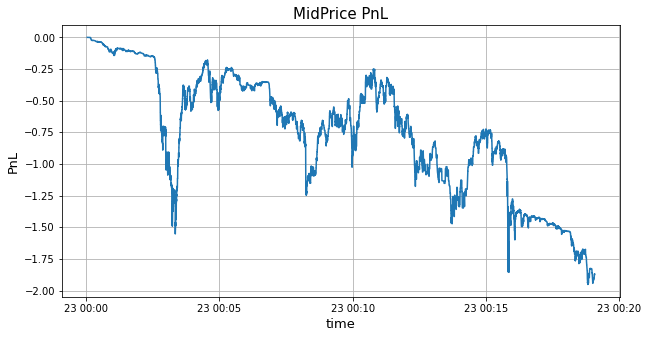

In [127]:
plt.figure(figsize=(10, 5))
plt.plot(dt, df.total, '-')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.title("MidPrice PnL", fontsize=15)
plt.grid()
plt.show()

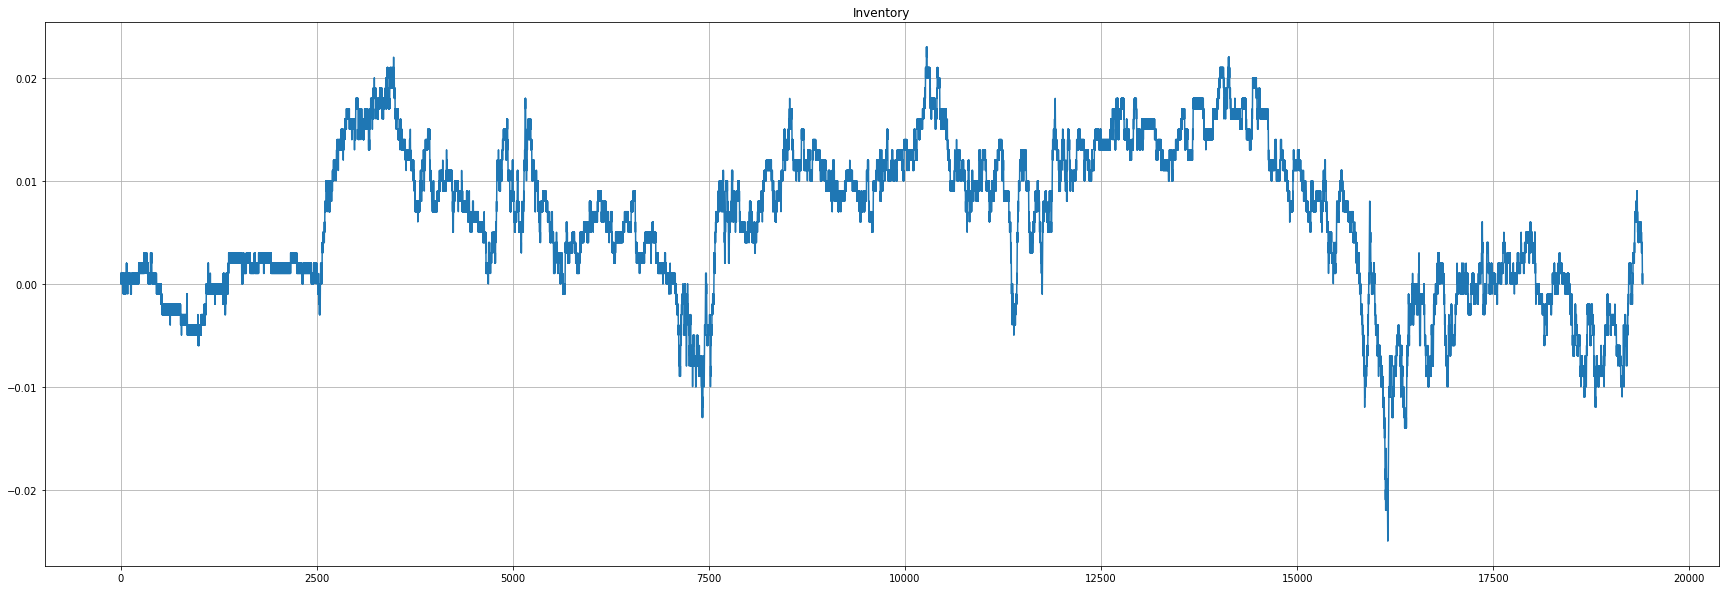

In [128]:
plt.figure(figsize=(30, 10))

plt.title("Inventory")
plt.plot(inventoryy)
plt.grid()
plt.show()